Image classification with CNNs
================

This notebook is based on the exercise notebooks of the course "Introduction to Deep Learning". We used a three-layer CNN to perform the classification task on the dataset CIFAR10 (32x32 images with 10 classes).

The bullet points are my suggestions what we need to do. 
****
The text below the grey lines is still from the original notebook.

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable


from exercise_code.classifiers.classification_cnn import ClassificationCNN
# specific for CIFAR10 dataset:
from exercise_code.data_utils import get_CIFAR10_datasets, OverfitSampler, rel_error

#torch.set_default_tensor_type('torch.FloatTensor')
#set up default cuda device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Dataset
=========

* Load the preprocessed datasets in patches of the same size (input size of network so far 32x32 pixel)
* Split data in train - val - test data
* How to treat unequal distribution of benign and malingant cases?

****
For an even easier management of the train, validation and test data pipelines we provide you with custom `torch.utils.data.Dataset` classes. Use the official [documentation](http://pytorch.org/docs/data.html) to make yourself familiar with the `Dataset` and `DataLoader` classes. Think about how you have to integrate them in your training loop and have a look at the data preprocessing steps in `dl4cv/data_utils.py`.

The `num_workers` argument of the `DataLoader` class allows you to preprocess data with multiple threads.

<div class="alert alert-info">
    <h3>Note</h3>
    <p>In this case we generated the <code>Dataset</code> classes after we applied all the preprocessing steps. Other datasets or random data augmentation might require an online preprocessing which can be integrated into the <code>Dataset</code> classes. See <code>torchvision.Transform</code> for examples.</p>
</div> 

In [22]:
### TODO

### i2dl code
# Load the (preprocessed) CIFAR10 data. The preprocessing includes
# channel swapping, normalization and train-val-test splitting.
# Loading the datasets might take a while.
train_data, val_data, test_data, mean_image = get_CIFAR10_datasets()
print("Train size: %i" % len(train_data))
print("Val size: %i" % len(val_data))
print("Test size: %i" % len(test_data))

Train size: 48000
Val size: 1000
Test size: 1000


Visualize Data
------------------
* Visualize some of the patches with according classlabels 

****
To make yourself familiar with the dataset we visualize some examples. We show a few examples from each class. Note that we have to revert (transposition and mean subtraction) some preprocessing steps.

In [ ]:
### TODO

## Train the Network

* Plot validation and training curve
* Hyperparameter optimization
* Visualize filters to see if network learns meaningful features

We can copy each of these methods from the notebooks 1_classification_cnn and 2_segmentation_nn


****


In [23]:
from exercise_code.classifiers.classification_cnn import ClassificationCNN
from exercise_code.solver import Solver

train_loader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=100, shuffle=False, num_workers=4)

############################################################################
# TODO: Initialize a model and train it using your Solver class. Start     #
# with the previously given set of hyperparameters.                        #
############################################################################

model = ClassificationCNN()
model.to(device)
solver = Solver(optim_args={"lr": 1e-3})
solver.train(model, train_loader, val_loader, log_nth=1000, num_epochs=10)

START TRAIN.
[Epoch 1/10] TRAIN acc/loss: 0.490/1.580
[Epoch 1/10] VAL   acc/loss: 0.513/1.354
[Epoch 2/10] TRAIN acc/loss: 0.570/1.428


Traceback (most recent call last):
  File "/Users/sophia/anaconda3/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/Users/sophia/anaconda3/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/sophia/anaconda3/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/Users/sophia/anaconda3/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: 

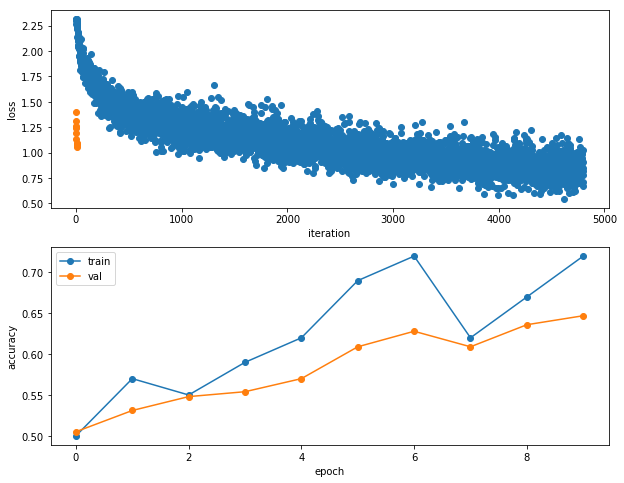

In [20]:
plt.subplot(2, 1, 1)
plt.plot(solver.train_loss_history, 'o')
plt.plot(solver.val_loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

# Test your Model
Run your best model on the test set.

## Save the Model